In [1]:
# !pip install skforecast==0.6.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


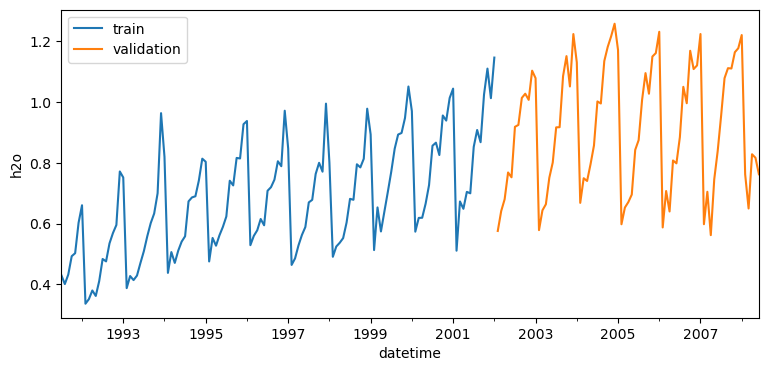

In [11]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
df = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
df['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
df = df.set_index('datetime')
df = df.asfreq('MS')
df = df[['y']]
df = df.sort_index()

# Train-validation dates
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {df.index.min()} --- {df.loc[:end_train].index.max()}  (n={len(df.loc[:end_train])})")
print(f"Validation dates : {df.loc[end_train:].index.min()} --- {df.index.max()}  (n={len(df.loc[end_train:])})")

# Plot
fig, ax = plt.subplots(figsize=(9, 4))
df.loc[:end_train].plot(ax=ax)
df.loc[end_train:].plot(ax=ax)
ax.set_ylabel('h2o')
ax.legend(['train', 'validation'])

## Backtest

The backtesting process adapted to this scenario is:

1. The model is trained with the series length set in initial_train_size.
2. It predicts and stores the next 10 steps, steps=10.
3. Since refit=True, the training set increases to a length of initial_train_size + steps, and the test data becomes the following 10 steps.
4. The model is re-trained with the new training set. The new 10 steps are then predicted.
5. This process is repeated until the entire series has been run.

In [21]:
from typing import Union, Tuple, Optional

In [22]:
# https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/skforecast/model_selection/model_selection.py

def backtesting_forecaster(
    forecaster,
    y: pd.Series,
    steps: int,
    metric: Union[str, callable, list],
    initial_train_size: Optional[int]=None,
    fixed_train_size: bool=True,
    exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
    refit: bool=False,
    interval: Optional[list]=None,
    n_boot: int=500,
    random_state: int=123,
    in_sample_residuals: bool=True,
    verbose: bool=False
) -> Tuple[Union[float, list], pd.DataFrame]:
    """
    Backtesting of forecaster model.
    If `refit` is False, the model is trained only once using the `initial_train_size`
    first observations. If `refit` is True, the model is trained in each iteration
    increasing the training set. A copy of the original forecaster is created so 
    it is not modified during the process.
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterAutoregCustom, ForecasterAutoregDirect
        Forecaster model.
        
    y : pandas Series
        Training time series.
    
    steps : int
        Number of steps to predict.
        
    metric : str, callable, list
        Metric used to quantify the goodness of fit of the model.
        
        If string:
            {'mean_squared_error', 'mean_absolute_error',
             'mean_absolute_percentage_error', 'mean_squared_log_error'}
    
        If callable:
            Function with arguments y_true, y_pred that returns a float.
        If list:
            List containing several strings and/or callable.
    
    initial_train_size : int, default `None`
        Number of samples in the initial train split. If `None` and `forecaster` is already 
        trained, no initial train is done and all data is used to evaluate the model. However, 
        the first `len(forecaster.last_window)` observations are needed to create the 
        initial predictors, so no predictions are calculated for them.
        `None` is only allowed when `refit` is `False`.
    
    fixed_train_size : bool, default `True`
        If True, train size doesn't increase but moves by `steps` in each iteration.
        
    exog : pandas Series, pandas DataFrame, default `None`
        Exogenous variable/s included as predictor/s. Must have the same
        number of observations as `y` and should be aligned so that y[i] is
        regressed on exog[i].
    refit : bool, default `False`
        Whether to re-fit the forecaster in each iteration.
    interval : list, default `None`
        Confidence of the prediction interval estimated. Sequence of percentiles
        to compute, which must be between 0 and 100 inclusive. For example, 
        interval of 95% should be as `interval = [2.5, 97.5]`. If `None`, no
        intervals are estimated. Only available for forecaster of type 
        ForecasterAutoreg and ForecasterAutoregCustom.
            
    n_boot : int, default `500`
        Number of bootstrapping iterations used to estimate prediction
        intervals.
    random_state : int, default `123`
        Sets a seed to the random generator, so that boot intervals are always 
        deterministic.
    in_sample_residuals : bool, default `True`
        If `True`, residuals from the training data are used as proxy of
        prediction error to create prediction intervals.  If `False`, out_sample_residuals
        are used if they are already stored inside the forecaster.
                  
    verbose : bool, default `False`
        Print number of folds and index of training and validation sets used for backtesting.

    Returns 
    -------
    metrics_value : float, list
        Value(s) of the metric(s).
    backtest_predictions : pandas DataFrame
        Value of predictions and their estimated interval if `interval` is not `None`.
            column pred = predictions.
            column lower_bound = lower bound of the interval.
            column upper_bound = upper bound interval of the interval.
    """
    pass

In [24]:
# https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/skforecast/model_selection_statsmodels/model_selection_statsmodels.py

def backtesting_sarimax(
    y: pd.Series,
    steps: int,
    metric: Union[str, callable],
    initial_train_size: int,
    fixed_train_size: bool=False,
    refit: bool=False,
    order: tuple=(1, 0, 0), 
    seasonal_order: tuple=(0, 0, 0, 0),
    trend: str=None,
    alpha: float= 0.05,
    exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
    sarimax_kwargs: dict={},
    fit_kwargs: dict={'disp':0},
    verbose: bool=False
) -> Tuple[float, pd.DataFrame]:
    """
    Backtesting (validation) of `SARIMAX` model from statsmodels >= 0.12. The model
    is trained using the `initial_train_size` first observations, then, in each
    iteration, a number of `steps` predictions are evaluated. If refit is `True`,
    the model is re-fitted in each iteration before making predictions.
    
    https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
    
    Parameters
    ----------
    y : pandas Series
        Time series values. 
    steps : int
        Number of steps to predict.
    metric : str, callable
        Metric used to quantify the goodness of fit of the model.
        
        If string:
            {'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'}
        If callable:
            Function with arguments y_true, y_pred that returns a float.
    initial_train_size: int 
        Number of samples used in the initial train.
    
    fixed_train_size: bool, default `False`
        If True, train size doesn't increases but moves by `steps` in each iteration.

    refit: bool, default False
        Whether to re-fit the model in each iteration.
        
    order: tuple 
        The (p,d,q) order of the model for the number of AR parameters, differences,
        and MA parameters. d must be an integer indicating the integration order
        of the process, while p and q may either be an integers indicating the AR
        and MA orders (so that all lags up to those orders are included) or else
        iterables giving specific AR and / or MA lags to include. Default is an
        AR(1) model: (1,0,0).
        
    seasonal_order: tuple
        The (P,D,Q,s) order of the seasonal component of the model for the AR parameters,
        differences, MA parameters, and periodicity. D must be an integer
        indicating the integration order of the process, while P and Q may either
        be an integers indicating the AR and MA orders (so that all lags up to
        those orders are included) or else iterables giving specific AR and / or
        MA lags to include. s is an integer giving the periodicity (number of
        periods in season), often it is 4 for quarterly data or 12 for monthly data.
        Default is no seasonal effect.
        
    trend: str {'n', 'c', 't', 'ct'}
        Parameter controlling the deterministic trend polynomial A(t). Can be
        specified as a string where 'c' indicates a constant (i.e. a degree zero
        component of the trend polynomial), 't' indicates a linear trend with time,
        and 'ct' is both. Can also be specified as an iterable defining the non-zero
        polynomial exponents to include, in increasing order. For example, [1,1,0,1]
        denotes a+bt+ct3. Default is to not include a trend component.
        
    alpha: float, default 0.05
        The significance level for the confidence interval. The default
        alpha = .05 returns a 95% confidence interval.
        
    exog : pandas Series, pandas DataFrame, default `None`
        Exogenous variable/s included as predictor/s. Must have the same
        number of observations as `y` and should be aligned so that y[i] is
        regressed on exog[i].
        
    sarimax_kwargs: dict, default `{}`
        Additional keyword arguments passed to SARIMAX constructor. See more in
        https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX
        
    fit_kwargs: dict, default `{'disp':0}`
        Additional keyword arguments passed to SARIMAX fit. See more in
        https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit
        
    verbose : bool, default `False`
        Print number of folds used for backtesting.
        
    Returns 
    -------
    metric_value: float
        Value of the metric.
    backtest_predictions: pandas DataFrame
        Values predicted and their estimated interval:
                column pred   = predictions.
                column lower  = lower bound of the interval.
                column upper  = upper bound interval of the interval.
    
    """
    pass

#### Backtesting with refit and increasing training size (fixed origin)

In [4]:
# Backtesting with refit and increasing training size
# ==============================================================================
forecaster = ForecasterAutoreg(
     regressor = RandomForestRegressor(random_state=123),
     lags      = 15 
 )

metric, predictions_backtest = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['y'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = True,
    verbose            = True
)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00  (n=137)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00  (n=147)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00  (n=157)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:0

In [12]:
metric, predictions_backtest = backtesting_sarimax(
    y = data,
    order              = (12, 1, 1),
    seasonal_order     = (0, 0, 0, 0),
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = True,
    verbose            = True,
    fit_kwargs         = {'maxiter': 250, 'disp': 0},
)
print(f"Backtest error: {metric}")

Number of observations used for training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.
Backtest error: 0.005647637136915969


#### Backtesting with refit and fixed training size (rolling origin)

In [15]:
# Backtesting with refit and fixed training size
# ==============================================================================
forecaster = ForecasterAutoreg(
     regressor = RandomForestRegressor(random_state=123),
     lags      = 15 
 )

metric, predictions_backtest = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['y'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = True,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = True,
    verbose            = True
)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1992-05-01 00:00:00 -- 2002-11-01 00:00:00  (n=127)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1993-03-01 00:00:00 -- 2003-09-01 00:00:00  (n=127)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1994-01-01 00:00:00 -- 2004-07-01 00:00:00  (n=127)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1994-11-01 00:00:00 -- 2005-05-01 00:00:0

In [18]:
metric, predictions_backtest = backtesting_sarimax(
    y = data,
    order              = (12, 1, 1),
    seasonal_order     = (0, 0, 0, 0),
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = True,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = True,
    verbose            = True,
    fit_kwargs         = {'maxiter': 250, 'disp': 0},
)
print(f"Backtest error: {metric}")

Number of observations used for training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.
Backtest error: 0.005685553405752285
            predicted_mean   lower y   upper y
2002-02-01        0.602712  0.508994  0.696429
2002-03-01        0.741958  0.642737  0.841179
2002-04-01        0.732213  0.628680  0.835746
2002-05-01        0.759293  0.651028  0.867557


#### Backtesting without refit

In [17]:
# Backtesting without refit
# ==============================================================================
forecaster = ForecasterAutoreg(
     regressor = RandomForestRegressor(random_state=123),
     lags      = 15 
 )

metric, predictions_backtest = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['y'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = False,
    verbose            = True
)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:0

In [16]:
metric, predictions_backtest = backtesting_sarimax(
    y = data,
    order              = (12, 1, 1),
    seasonal_order     = (0, 0, 0, 0),
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    steps              = 10,
    metric             = 'mean_squared_error',
    refit              = False,
    verbose            = True,
    fit_kwargs         = {'maxiter': 250, 'disp': 0},
)
print(f"Backtest error: {metric}")

Number of observations used for training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.
Backtest error: 0.0054407680396108184
            predicted_mean   lower y   upper y
2002-02-01        0.602712  0.508994  0.696429
2002-03-01        0.741958  0.642737  0.841179
2002-04-01        0.732213  0.628680  0.835746
2002-05-01        0.759293  0.651028  0.867557
